In [1]:
import io
import cv2
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
def zip2ram(filename):
    """ Carga un archivo zip en memoria. Retorna un diccionario[str,bytes] """
    result = {}
    with ZipFile(filename, mode="r") as archive:
        for info in archive.infolist():
            key = info.filename
            value = archive.read(key)
            result[key] = value
    return result

dataset = zip2ram('dataset.zip')

In [3]:
def get_image_batch(dataset, batch_size=32):
    size_dataset = len(dataset.keys()) // 4  # 1 input + 3 outputs
    input, output_1, output_2 = [], [], []

    idxs = np.random.choice(range(size_dataset), batch_size, replace=False)

    for idx in idxs:
        key_input = f'img_{idx}.npz'
        key_outputs = [f'img_backgound_{idx}.png', f'img_pretil_binary_{idx}.png', f'img_pretil_{idx}.png']

        byte_input = dataset.get(key_input)
        load_bytes = io.BytesIO(byte_input)
        input_image = np.load(load_bytes, allow_pickle=True)['arr_0']

        outputs = []
        for key_output in key_outputs:
            byte_output = dataset.get(key_output)
            if byte_output:
                output = cv2.imdecode(np.frombuffer(byte_output, dtype="uint8"), cv2.IMREAD_GRAYSCALE)
                outputs.append(output)
        
        outputs_binary = np.stack((outputs[0],outputs[1]),axis=-1)
        output_1.append(outputs_binary)
        output_2.append(np.expand_dims(outputs[2], axis=-1))  
        input.append(np.expand_dims(input_image, axis=-1))
        
    return np.array(input, dtype=np.float32), np.array(output_1, dtype=np.float32) / 255, np.array(output_2, dtype=np.float32) / 255 

i, o1, o2 = get_image_batch(dataset, 4)
print(i.shape, o1.shape, o2.shape)
print(type(i), type(o1), type(o2))
print(i.dtype, o1.dtype, o2.dtype)
print(np.max(i), np.max(o1), np.max(o2))

(4, 512, 512, 1) (4, 512, 512, 2) (4, 512, 512, 1)
<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
float32 float32 float32
1.089007 1.0 1.0


In [4]:
INPLACE=False 
CONVPAD='zeros'

def pt_get_activation(activation) -> nn.Module:
    """ Retorna un modulo de activacion por nombre.
    Retorna None si el nombre no coincide """
    if(activation is None): return None
    elif isinstance(activation,nn.Module): return activation
    elif(activation=='relu'): return nn.ReLU(inplace=INPLACE)
    elif(activation=='elu'): return nn.ELU(inplace=INPLACE)
    elif(activation=='leakyrelu'): return nn.LeakyReLU(inplace=INPLACE)
    elif(activation=='sigmoid'): return nn.Sigmoid()
    elif(activation=='logsigmoid'): return nn.LogSigmoid()
    elif(activation=='softmax'): return nn.Softmax(dim=1)
    elif(activation=='softmin'): return nn.Softmin(dim=1)
    elif(activation=='logsoftmax'): return nn.LogSoftmax(dim=1)
    elif(activation=='prelu'): return nn.PReLU()
    elif(activation=='relu6'): return nn.ReLU6(inplace=INPLACE)
    elif(activation=='rrelu'): return nn.RReLU(inplace=INPLACE)
    elif(activation=='selu'): return nn.SELU(inplace=INPLACE)
    elif(activation=='celu'): return nn.CELU(inplace=INPLACE)
    elif(activation=='gelu'): return nn.GELU(approximate='tanh')
    elif(activation=='silu'): return nn.SiLU(inplace=INPLACE)
    elif(activation=='mish'): return nn.Mish(inplace=INPLACE)
    elif(activation=='softplus'): return nn.Softplus()
    elif(activation=='softsign'): return nn.Softsign()
    elif(activation=='softshrink'): return nn.Softshrink()
    elif(activation=='tanh'): return nn.Tanh()
    return None

class Conv(nn.Module):
    """ Convolution + Activation """
        
    def __init__(self, ic:int, oc:int, k=3, s=1, p=1, bias=True, activation=None, scale=None, residual=False):
        super().__init__()
        self.conv = nn.Conv2d(ic, oc, kernel_size=k, stride=s, padding=p, bias=bias, padding_mode=CONVPAD)
        self.activation = pt_get_activation(activation)
        self.scale = scale
        self.residual = residual
        
    def forward(self, x):
        x0 = x
        x = self.conv(x)
        if(self.activation is not None): x = self.activation(x)
        if(self.scale is not None): x = self.scale(x)
        if(self.residual): x = x0 + x
        return x
    
class ResID07(nn.Module):
    """ Bloque residual bn+act+conv+bn+act+conv con ajuste de dimensiones espaciales y semanticas """ 
    def __init__(self, ic:int, oc:int, activation='relu', dropout=0.0, expansion=1, resample=None):
        super().__init__()
        mc = int(ic*expansion)
        self.norm1 = torch.nn.BatchNorm2d(ic, momentum=0.01)
        self.act1  = pt_get_activation(activation) 
        self.conv1 = Conv(ic,mc,k=3,s=1,p=1)
        
        self.resample = resample
        
        self.norm2 = torch.nn.BatchNorm2d(mc, momentum=0.01)
        self.act2  = pt_get_activation(activation)
        self.dropout = nn.Dropout(dropout) if dropout>0.0 else None
        self.conv2 = Conv(mc,oc,k=3,s=1,p=1)
        
        self.conv3 = Conv(ic,oc,k=1,s=1,p=0) if ic!=oc else None
        
    def forward(self, x, emb=None):
        x0 = x
        if(self.norm1 is not None): x = self.norm1(x)
        if(self.act1  is not None): x = self.act1(x)
        x = self.conv1(x)
        
        if(emb is not None): x = x+emb
        
        if(self.resample is not None):
            x  = F.interpolate(x, scale_factor=self.resample, mode='bilinear')
            x0 = F.interpolate(x0,scale_factor=self.resample, mode='bilinear')
        
        if(self.norm2   is not None): x = self.norm2(x)
        if(self.act2    is not None): x = self.act2(x)
        if(self.dropout is not None): x = self.dropout(x)
        x = self.conv2(x)
        
        if self.conv3 is not None: x0 = self.conv3(x0) #(b,oc,h,w) Ajusta los canales para que sean iguales.
        
        return x0 + x
    
class ResID07N(nn.Module):
    """ N bloques ResID07 """
    def __init__(self, ic:int, n=2, activation='relu', dropout=0.0, expansion=2):
        super().__init__()
        self.layers = []
        for _ in range(n): self.layers.append(ResID07(ic,ic, activation=activation, dropout=dropout, expansion=expansion))
        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x)

class UNetSam(nn.Module):
    """ UNET
    La primera seccion aplica ResID07 con resample=0.5 varias veces para reducir  la resolucion y aumentar la cantidad de filtros, hasta llegar a la maxima cantidad de filtros.
    La segunda seccion aplica ResID07 con resample=2.0 varias veces para aumentar la resolucion y reducir  la cantidad de filtros.
    Agrega enlaces entre la primera y segunda seccion.
    Retorna una lista 'y' con todas las salidas de cada nivel, siendo y[0] la entrada e y[-1] la ultima salida
    activation2: Activacion de SAM: sigmoid, softmax8, softmax16, softmax32
    """
    
    def __init__(self, filters=(1,16,32,64,128,256,128,64,32,16), n=1, activation='relu', dropout=0.0, expansion=1):
        super().__init__()
        c = len(filters) #Total de filtros
        j = np.argmax(filters) #Indice de la mayor cantidad de filtros (Parte mas ancha de la UNet)
        
        self.convs = nn.ModuleList() #Lista de modulos ConvBnAct
        self.convs_res = nn.ModuleList() #Lista de modulos ResID01N

        for i in range(1,j+1):
            f1 = filters[i-1]
            f2 = filters[i]
            self.convs.append( ResID07(f1,f2,resample=0.5,activation=activation, dropout=dropout, expansion=expansion))
            module = ResID07N(f2,n=n,activation=activation, dropout=dropout, expansion=expansion)
            self.convs_res.append(module)
            
        self.convts = nn.ModuleList() #Lista de modulos ConvTBnAct (Convolucion Transpuesta)
        self.convts_res = nn.ModuleList() #Lista de modulos ResID01N
        self.links = nn.ModuleList() #Lista de modulos ConvBnAct para enlazar la primera seccion con la segunda
        for i in range(j+1,c):
            f1 = filters[i-1]
            f2 = filters[i]
            self.convts.append(ResID07(f1,f2,resample=2,activation=activation, dropout=dropout, expansion=expansion))
            module = ResID07N(f2,n=n,activation=activation, dropout=dropout, expansion=expansion)
            self.convts_res.append(module)
            self.links.append(ResID07N(f2,n=n,activation=activation, dropout=dropout, expansion=expansion))
            
        self.c = c #Total de filtros
        self.j = j #Indice de la mayor cantidad de filtros

    def forward(self, x):
        """ x:(b,c,h,w) """

        y = [x] #Lista de salidas. El primer valor de salida es la entrada
        g=0
        for conv,res  in zip(self.convs, self.convs_res): #Por cada convolucion de la primera seccion
            x = conv(x) #Aplica la convolucion
            
            x = res(x) #Aplica residual
            y.append(x) #Guarda la salida
            
        i=1
        j=self.j
        for convt,res,link in zip(self.convts, self.convts_res, self.links): #Por cada convolucion transpuesta y enlace
            x = convt(x) #Aplica la convolucion transpuesta 
            
            x = res(x) #Aplica residual
            if(j-i>=0): x=x+link(y[j-i]) #Aplica el enlace a la primera seccion
            i+=1
            y.append(x) #Guarda la salida
        
        return y #Retorna una lista con todas las salidas
    

class Unet(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.unet = UNetSam(filters=(1,16,32,64,128,256,128,64,32,16), n=1, activation='relu', dropout=0.0, expansion=1)
        self.convT_o1 = nn.ConvTranspose2d(16, 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.convT_o2 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        

    def forward(self, x):
        y = self.unet(x)
        y1 = self.convT_o1(y[-1])
        output_pretil = self.convT_o2(y[-1])

        output_binary = F.softmax(y1, dim=1)        
        return output_binary, output_pretil

model = Unet()
model.cuda()

#x = torch.rand((1,1,512,512))
#output_binary, output_pretil = model(x)
#output_binary.shape, output_pretil.shape


Unet(
  (unet): UNetSam(
    (convs): ModuleList(
      (0): ResID07(
        (norm1): BatchNorm2d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (act1): ReLU()
        (conv1): Conv(
          (conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): BatchNorm2d(1, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (act2): ReLU()
        (conv2): Conv(
          (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (conv3): Conv(
          (conv): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (1): ResID07(
        (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (act1): ReLU()
        (conv1): Conv(
          (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=T

In [5]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [6]:
#TODO
epochs = 10 
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def pt_loss_mse(y_pred, y_true):
    """ Mean of Square Error. Retorna un scalar  """
    return F.mse_loss(y_pred, y_true, reduction='mean') #Retorna un scalar

def pt_loss_mbce(y_pred, y_true):
    """ Mean of Binary Cross Entropy. Retorna un scalar  """
    return F.binary_cross_entropy(y_pred, y_true, reduction='mean')

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for i in range(0, len(dataset.keys()) // 4, batch_size):
        input_image, output_binary, output_pretil  = get_image_batch(dataset, batch_size)

        # Preprocesamiento
        input_image = torch.tensor(input_image, dtype=torch.float32, device=device)
        output_binary = torch.tensor(output_binary, dtype=torch.float32, device=device)
        output_pretil = torch.tensor(output_pretil, dtype=torch.float32, device=device)
        input_image = input_image.permute(0, 3, 1, 2)
        output_binary = output_binary.permute(0, 3, 1, 2)
        output_pretil = output_pretil.permute(0, 3, 1, 2)
        # Forward
        pred_binary, pred_pretil = model(input_image)
        # Loss
        loss1 = pt_loss_mbce(pred_binary, output_binary)
        loss2 = pt_loss_mse(pred_pretil, output_pretil)
        loss = loss1 + loss2
        # Backward
        loss.backward() # Calcula los gradientes
        torch.nn.utils.clip_grad_value_(model.parameters(), 1) # Evita el exploding gradient
        optimizer.step() # Actualiza los pesos
        optimizer.zero_grad()

        with torch.no_grad():
            recall = None
            precision = None 
            f1_score = None

    print(f"Loss: {loss.item()}")
    print(f"Loss1: {loss1.item()}")
    print(f"Loss2: {loss2.item()}")


Epoch 1/10
Loss: 0.038890108466148376
Loss1: 0.02578034996986389
Loss2: 0.013109758496284485
Epoch 2/10
Loss: 0.036672987043857574
Loss1: 0.02839289978146553
Loss2: 0.008280088193714619
Epoch 3/10
Loss: 0.01953303813934326
Loss1: 0.01619630865752697
Loss2: 0.0033367304131388664
Epoch 4/10
Loss: 0.01500607468187809
Loss1: 0.011092830449342728
Loss2: 0.003913244232535362
Epoch 5/10
Loss: 0.02049475908279419
Loss1: 0.016322296112775803
Loss2: 0.004172462038695812
Epoch 6/10
Loss: 0.013469716534018517
Loss1: 0.011084703728556633
Loss2: 0.00238501257263124
Epoch 7/10
Loss: 0.011785261332988739
Loss1: 0.009392580017447472
Loss2: 0.0023926817812025547
Epoch 8/10
Loss: 0.012404065579175949
Loss1: 0.007646427024155855
Loss2: 0.004757639020681381
Epoch 9/10
Loss: 0.01041075587272644
Loss1: 0.008563454262912273
Loss2: 0.0018473018426448107
Epoch 10/10
Loss: 0.012180826626718044
Loss1: 0.011047044768929482
Loss2: 0.0011337820906192064


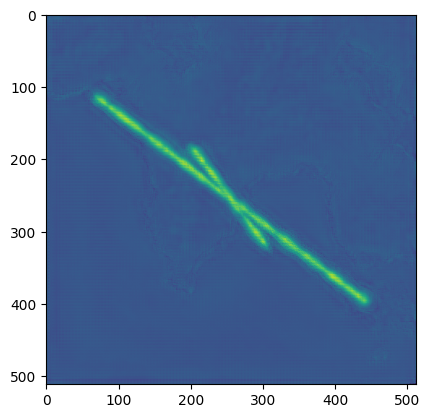

In [10]:
input_image, _, _  = get_image_batch(dataset, batch_size)
input_image = torch.tensor(input_image, dtype=torch.float32, device=device)
input_image = input_image.permute(0, 3, 1, 2)

binary, pretil = model(input_image)
plt.imshow(pretil[0].cpu().detach().numpy().transpose(1, 2, 0))

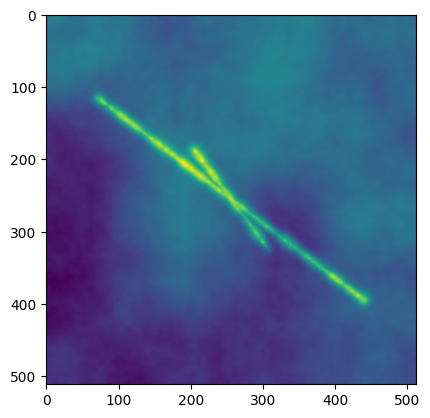

In [11]:
plt.imshow(input_image[0].cpu().detach().numpy().transpose(1, 2, 0))

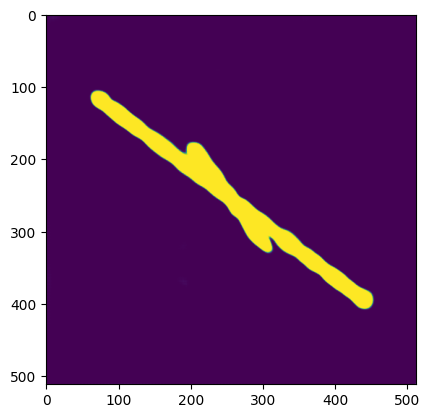

In [18]:
plt.imshow(binary[0].cpu().detach().numpy().transpose(1, 2, 0)[:,:,1])